We will use the lemonade inc data we scraped in the earlier script to create a regression model to predict returns based on features already in the dataset and some new features we will engineer. We will be predicting 5 day forward returns based on historical data.

In [3]:
import pandas as pd

df = pd.read_csv("Data/lmnd_daily_5y.csv", parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date")


df.head()

# print the column names
print(df.columns)

# print number of data point total 
print(f"Total data points: {len(df)}")

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Total data points: 1254


In [4]:
# create daily returns colum as a new feature
df["ret_daily"] = df["Adj Close"].pct_change()
df.head()


,Adj Close,Close,High,Low,Open,Volume,ret_daily
Date,,,,,,,
2020-12-02,66.830002,66.830002,67.110001,62.310001,65.389999,1059000,NaN
2020-12-03,80.349998,80.349998,83.169998,65.919998,66.989998,9344400,0.202304
2020-12-04,85.040001,85.040001,85.949997,78.029999,82.500000,5463900,0.058370
2020-12-07,91.720001,91.720001,99.989998,88.019997,90.029999,7528100,0.078551
2020-12-08,90.599998,90.599998,97.650002,89.349998,97.309998,3844500,-0.012211


In [3]:
# 5 day horizon
horizon = 5  

# what we are doing here is basically for any given day, we want to know what the adjusted close price will be after our horizon (6 months in our case)
df["AdjClose_future"] = df["Adj Close"].shift(-horizon)
# now we can calculate the forward return over the 6 month horizon
df["fwd_5d_ret"] = (df["AdjClose_future"] - df["Adj Close"]) / df["Adj Close"]

In [4]:


# we will drop an rows with NaN values that were created due to pct_change and shift operations
df = df.dropna()
df.head()

# check now many data points we have
print(f"Number of data points after initial feature engineering: {len(df)}")

Number of data points after initial feature engineering: 1248


we need features that capture momentum and volatility

In [5]:
import numpy as np
#momentum Features (capturing trends over ~1, 3, and 6 months)
df['ret_21d_mean'] = df['ret_daily'].rolling(window=21).mean()
df['ret_63d_mean'] = df['ret_daily'].rolling(window=63).mean()
df['ret_126d_mean'] = df['ret_daily'].rolling(window=126).mean()

# print how many nan values we have after adding momentum features
print(f"Number of NaN values after adding momentum features: {df.isna().sum().sum()}")

# Volatility Features (capturing risk over ~1, 3, and 6 months)
df['vol_21d'] = df['ret_daily'].rolling(window=21).std()
df['vol_63d'] = df['ret_daily'].rolling(window=63).std()
df['vol_126d'] = df['ret_daily'].rolling(window=126).std()


df['log_volume'] = np.log(df['Volume'])

df['vol_rel_21d'] = df['log_volume'] - df['log_volume'].rolling(21).mean()

feature_variables = [
    'ret_21d_mean', 'ret_63d_mean', 'ret_126d_mean',
    'vol_21d', 'vol_63d', 'vol_126d',
    'vol_rel_21d' 
]

target_variable = 'fwd_5d_ret'

# print how many nan values we have after adding volatility features
print(f"Number of NaN values after adding volatility features: {df.isna().sum().sum()}")

# how many rows have NaN values now -- print
print(f"Number of rows with NaN values: {df.isna().any(axis=1).sum()}")

# drop rows with NaN values
df = df.dropna()

print(f"Number of data points after feature engineering: {len(df)}")




Number of NaN values after adding momentum features: 207
Number of NaN values after adding volatility features: 434
Number of rows with NaN values: 125
Number of data points after feature engineering: 1123


Best Alpha: 100.0
R² Score: -0.0401
RMSE: 0.1096


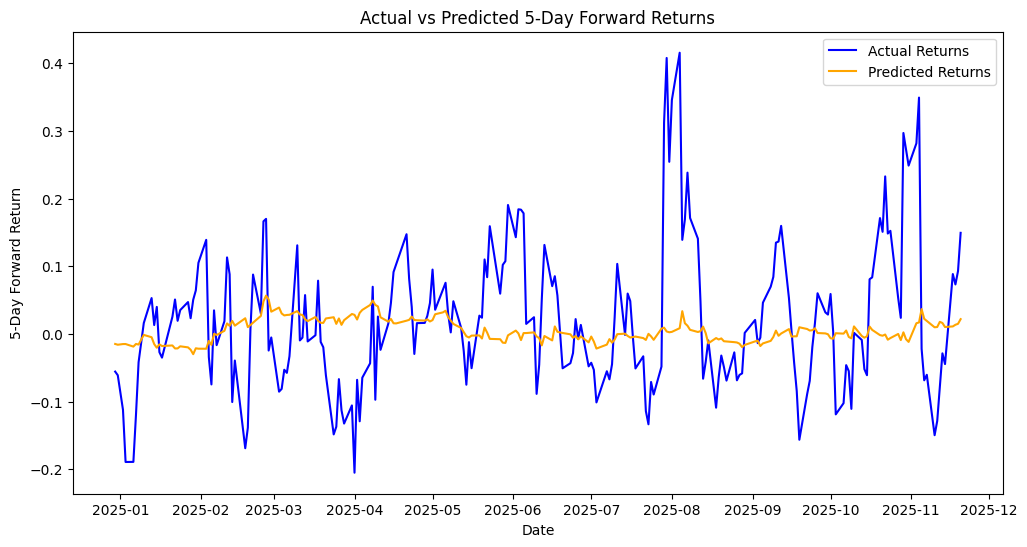

In [ ]:



# implement ridge regression model
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



X = df[feature_variables]
y = df['fwd_5d_ret']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# RidgeCV automatically finds the best alpha (penalty strength)
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
ridge.fit(X_train, y_train)

# Predict
y_pred = ridge.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Best Alpha: {ridge.alpha_}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
# graph of the error distribution
import seaborn as sns

sns.histplot(y_test - y_pred, bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()
# create graph to compare actual vs predicted returns
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Returns', color='orange')
plt.xlabel('Date')
plt.ylabel('5-Day Forward Return')
plt.title('Actual vs Predicted 5-Day Forward Returns')
plt.legend()
plt.show()  


we will switch randomforest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Use 100 trees, limit depth to prevent overfitting
rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Metrics (regression)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"RandomForestRegressor R²: {r2_rf:.4f}")
print(f"RandomForestRegressor RMSE: {rmse_rf:.4f}")




RandomForestRegressor R²: -0.0467
RandomForestRegressor RMSE: 0.1100
